In [1]:
import sys
sys.path.append('..')
from load_datasets import load_image, show_image_with_bbox, show_image_with_two_bboxes
from sodnet_funcs import fit_sodnet, test_sodnet, ToTensor, ToPILImage, get_adam_loaders, ResBlock, SODNet, iou_batch

import numpy as np
import pandas as pd
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'CUDA enabled: {use_cuda}')

CUDA enabled: True


In [2]:
root = '../../datasets/ADAM/Training1200'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')

display(fovea.head())
display(fovea.tail())

,imgName,Fovea_X,Fovea_Y
ID,,,
0,A0001.jpg,142.495130,127.255264
1,A0001-1.jpg,173.229593,152.780556
2,A0001-2.jpg,142.495130,127.255264
3,A0002.jpg,116.640789,126.623708
4,A0002-1.jpg,116.640789,129.376292


,imgName,Fovea_X,Fovea_Y
ID,,,
1180,N0310-1.jpg,121.887742,147.226449
1181,N0310-2.jpg,121.887742,147.226449
1182,N0311.jpg,132.273929,134.670017
1183,N0311-1.jpg,132.273929,134.670017
1184,N0311-2.jpg,132.273929,134.670017


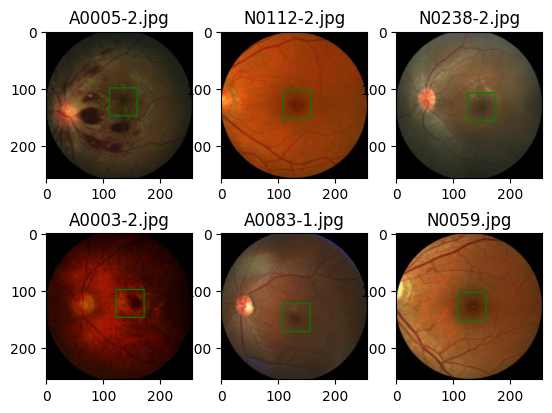

In [3]:
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(fovea.index, size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = load_image(fovea, idx, root=root)
	show_image_with_bbox(fovea, img, bbox, ax=ax, idx=idx)

torch.float32 tensor(0.3765)


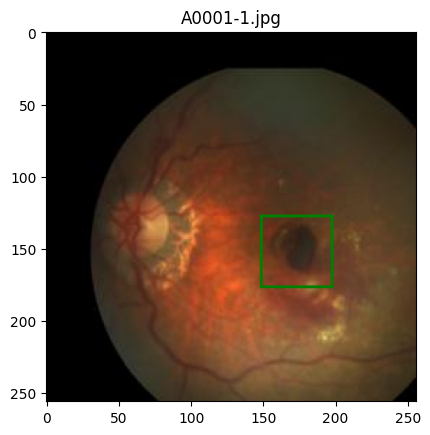

In [4]:
init_sample = load_image(fovea, 1, root=root)
transform = ToTensor()
img, bbox = transform(init_sample)
print(img.dtype, img[0][100][100])
img, bbox = ToPILImage()((img, bbox))
show_image_with_bbox(fovea, img, bbox, idx=1)

In [5]:
train_dl, test_dl = get_adam_loaders(8, cutoff=0.8, root=root)
print(len(train_dl))
image_batch, labels_batch = next(iter(train_dl))
print(image_batch.shape, image_batch.dtype)
print(labels_batch, labels_batch.dtype)

119
torch.Size([8, 3, 256, 256]) torch.float32
tensor([[0.3414, 0.2995],
        [0.7554, 0.6605],
        [0.5114, 0.5081],
        [0.4986, 0.5054],
        [0.5356, 0.5140],
        [0.4820, 0.5669],
        [0.5108, 0.5290],
        [0.4801, 0.5355]]) torch.float32


In [2]:
resblock = ResBlock(3, 16).to("cpu")
summary(resblock, input_size=(3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              84
       BatchNorm2d-2          [-1, 3, 256, 256]               6
              ReLU-3          [-1, 3, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             448
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
Total params: 570
Trainable params: 570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 28.50
Params size (MB): 0.00
Estimated Total Size (MB): 29.25
----------------------------------------------------------------


In [6]:
model = SODNet(3, 16)
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              84
       BatchNorm2d-2          [-1, 3, 256, 256]               6
              ReLU-3          [-1, 3, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             448
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
          ResBlock-7         [-1, 16, 256, 256]               0
         MaxPool2d-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           2,320
      BatchNorm2d-10         [-1, 16, 128, 128]              32
             ReLU-11         [-1, 16, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           4,640
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14         [-1, 32, 1

In [7]:
epochs = 30
loss_tracking = {'train': [], 'val': []}
iou_tracking = {'train': [], 'val': []}

model = SODNet(3, 16).to(device)
loss_func = nn.SmoothL1Loss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(1, epochs + 1):

	train_loss, train_iou = fit_sodnet(model, device, train_dl, loss_func, optimizer)
	loss_tracking['train'].append(train_loss)
	iou_tracking['train'].append(train_iou)

	# unnecessary in benchmarking script
	with torch.inference_mode():
		val_loss, val_iou = test_sodnet(model, device, test_dl, loss_func)
		loss_tracking['val'].append(val_loss)
		iou_tracking['val'].append(val_iou)

	# training history can be collected outside the fit func
	print('[%d]\tTrain loss: %.4f\tTrain IoU: %.4f\tVal loss: %.4f\tVal IoU: %.4f'
	   % (epoch, train_loss, train_iou, val_loss, val_iou))

[1]	Train loss: 0.0375	Train IoU: 0.1935	Val loss: 0.0060	Val IoU: 0.3705
[2]	Train loss: 0.0090	Train IoU: 0.3063	Val loss: 0.0170	Val IoU: 0.1490
[3]	Train loss: 0.0057	Train IoU: 0.3650	Val loss: 0.0060	Val IoU: 0.3625
[4]	Train loss: 0.0045	Train IoU: 0.4116	Val loss: 0.0059	Val IoU: 0.4039
[5]	Train loss: 0.0034	Train IoU: 0.4508	Val loss: 0.0045	Val IoU: 0.4408
[6]	Train loss: 0.0034	Train IoU: 0.4542	Val loss: 0.0043	Val IoU: 0.4151
[7]	Train loss: 0.0034	Train IoU: 0.4629	Val loss: 0.0042	Val IoU: 0.4744
[8]	Train loss: 0.0032	Train IoU: 0.4756	Val loss: 0.0040	Val IoU: 0.4755
[9]	Train loss: 0.0034	Train IoU: 0.4708	Val loss: 0.0031	Val IoU: 0.5044
[10]	Train loss: 0.0032	Train IoU: 0.4804	Val loss: 0.0044	Val IoU: 0.4486
[11]	Train loss: 0.0028	Train IoU: 0.5052	Val loss: 0.0034	Val IoU: 0.5203
[12]	Train loss: 0.0027	Train IoU: 0.5065	Val loss: 0.0068	Val IoU: 0.3384
[13]	Train loss: 0.0027	Train IoU: 0.4964	Val loss: 0.0052	Val IoU: 0.4369
[14]	Train loss: 0.0039	Train IoU:

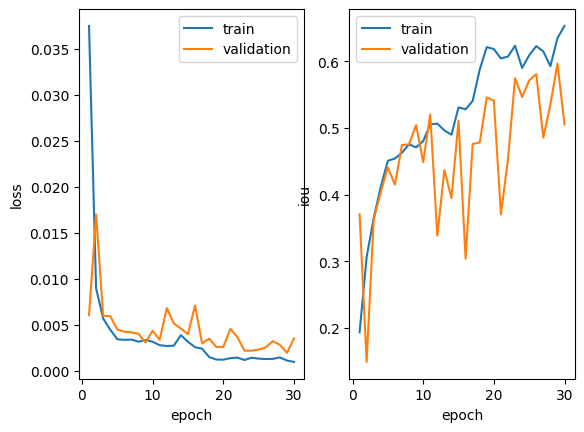

In [8]:
fig, axes = plt.subplots(1, 2)

axes[0].plot([i for i in range(1, epochs+1)], loss_tracking['train'], label='train')
axes[0].plot([i for i in range(1, epochs+1)], loss_tracking['val'], label='validation')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot([i for i in range(1, epochs+1)], iou_tracking['train'], label='train')
axes[1].plot([i for i in range(1, epochs+1)], iou_tracking['val'], label='validation')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('iou')
axes[1].legend()

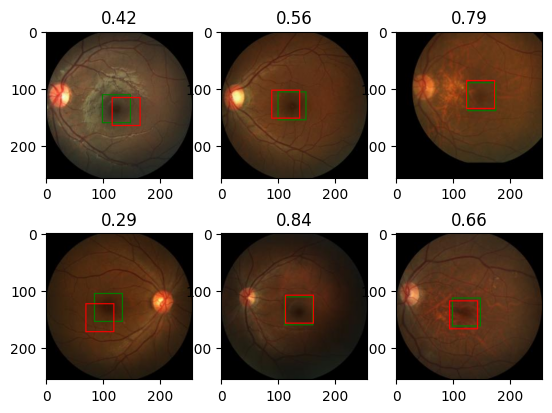

In [10]:
model.eval()

test_ds = test_dl.dataset
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(range(len(test_ds)), size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = test_ds[idx]
	img, bbox = img.to(device), bbox.to(device)

	output = model(torch.unsqueeze(img, 0))
	iou = iou_batch(output, torch.unsqueeze(bbox, 0), device=device)

	_, target_bbox = ToPILImage()((img, bbox))
	img, eval_bbox = ToPILImage()((img, output.squeeze()))
	show_image_with_two_bboxes(img, target_bbox, eval_bbox, title=f'{iou:.2f}', ax=ax)